This is an adaption of the implementation in https://github.com/LeanManager/NLP-PyTorch/blob/master/Character-Level%20LSTM%20with%20PyTorch.ipynb

# Character-Level LSTM in PyTorch

In this notebook, I'll construct a character-level LSTM with PyTorch. The network will train character by character on some text, then generate new text character by character. As an example, we will train on the songs by the Bernese song-writer Mani Matter!

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn). Below is the general architecture of the character-wise RNN.

<img src="https://github.com/LeanManager/NLP-PyTorch/raw/master/assets/charseq.jpeg" width="500">

First let's load in our required resources for data loading and model creation.

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


## Load in Data

Then, we'll load the Anna Karenina text file and convert it into integers for our network to use. 

### Tokenization

In the second cell, below, I'm creating a couple **dictionaries** to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [41]:
# open a text file and read in data as `text`
with open('dylan.txt', 'r') as f:
    text = f.read()

Now we have the text, encode it as integers.

In [42]:
# encode the text and map each character to an integer and vice versa

# we create two dictonaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in text])

Let's check out the first 100 characters:

In [43]:
text[:100]

'Well, my nerves are exploding and my body’s tense\nI feel like the whole world got me pinned up again'

And we can see those same characters encoded as integers.

In [44]:
encoded[:100]

array([52, 49, 68, 68, 82, 50, 88, 53, 50, 24, 49, 70, 22, 49, 45, 50, 27,
       70, 49, 50, 49, 48, 31, 68, 51,  7, 61, 24, 81, 50, 27, 24,  7, 50,
       88, 53, 50,  4, 51,  7, 53, 76, 45, 50,  8, 49, 24, 45, 49, 26, 65,
       50, 78, 49, 49, 68, 50, 68, 61, 28, 49, 50,  8, 72, 49, 50, 46, 72,
       51, 68, 49, 50, 46, 51, 70, 68,  7, 50, 81, 51,  8, 50, 88, 49, 50,
       31, 61, 24, 24, 49,  7, 50, 21, 31, 50, 27, 81, 27, 61, 24])

## Pre-processing the data

As you can see in our char-RNN image above, our LSTM expects an input that is **one-hot encoded** meaning that each character is converted into an intgere (via our created dictionary) and *then* converted into a column vector where only it's corresponsing integer index will have the value of 1 and the rest of the vector will be filled with 0's. Since we're one-hot encoding the data, let's make a function to do that!


In [45]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

## Making training mini-batches


To train on this data, we also want to create mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. 


<br>

In this example, we'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `n_seqs` (also refered to as "batch size" in other places). Each of those sequences will be `n_steps` long.

### Creating Batches

**1. The first thing we need to do is discard some of the text so we only have completely full batches. **

Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the total number of batches, $K$, we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

**2. After that, we need to split `arr` into $N$ sequences. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.


In [46]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size]
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:, n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

### Test Your Implementation

Now I'll make some data sets and we can check out what's going on as we batch data. Here, as an example, I'm going to use a batch size of 10 and 50 sequence steps.

In [47]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [48]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[52 49 68 68 82 50 88 53 50 24]
 [27 50 68 61  8  8 68 49 50 28]
 [49 50 51 78 50 64 51 53 26  3]
 [24 51 50 31 61 81 50 46 61  8]
 [72 50 72 61 45 50  8 51 24 81]
 [51  7 53 50 45 27 53 45 26  3]
 [27  5 28 50  8 51 51  8 72 26]
 [24 50  4 27  4 61 49 45 50 46]
 [51 31 49 68 68 49 70 45 50  8]
 [51 50 45 51 21  8 72 26 79 21]]

y
 [[49 68 68 82 50 88 53 50 24 49]
 [50 68 61  8  8 68 49 50 28 24]
 [50 51 78 50 64 51 53 26  3 72]
 [51 50 31 61 81 50 46 61  8 72]
 [50 72 61 45 50  8 51 24 81 21]
 [ 7 53 50 45 27 53 45 26  3 72]
 [ 5 28 50  8 51 51  8 72 26 58]
 [50  4 27  4 61 49 45 50 46 27]
 [31 49 68 68 49 70 45 50  8 72]
 [50 45 51 21  8 72 26 79 21 45]]


---
## Defining the network with PyTorch

Below is where you'll define the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="https://github.com/LeanManager/NLP-PyTorch/raw/master/assets/charRNN.png?raw=1" width=500px>

Next, you'll use PyTorch to define the architecture of the network. We start by defining the layers and operations we want. Then, define a method for the forward pass. You've also been given a method for predicting characters.

### Model Structure

In `__init__` the suggested structure is as follows:
* Create and store the necessary dictionaries (this has been done for you)
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `dropout_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights (again, this has been given)

Note that some parameters have been named and given in the `__init__` function, and we use them and store them by doing something like `self.drop_prob = drop_prob`.

---
### LSTM Inputs/Outputs

You can create a basic LSTM cell as follows

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. Finally, in the `forward` function, we can stack up the LSTM cells into layers using `.view`. With this, you pass in a list of cells and it will send the output of one cell into the next cell.

We also need to create an initial cell state of all zeros. This is done like so

```python
self.init_weights()
```

In [49]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
        
        # initialize the weights
        self.init_weights()
      
    
    def forward(self, x, hc):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hc`. '''
        
        ## TODO: Get x, and the new hidden state (h, c) from the lstm
        x, (h, c) = self.lstm(x, hc)
        
        ## TODO: pass x through a droupout layer
        x = self.dropout(x)
        
        # Stack up LSTM outputs using view
        x = x.reshape(x.size()[0]*x.size()[1], self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        x = self.fc(x)
        
        # return x and the hidden state (h, c)
        return x, (h, c)
    
    
    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.
        
            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()
        
        if h is None:
            h = self.init_hidden(1)
        
        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = torch.from_numpy(x)
        if cuda:
            inputs = inputs.cuda()
        
        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()
        
        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
            
        return self.int2char[char], h
    
    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1
        
        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)
        
    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())
        

### A note on the `predict`  function

The output of our RNN is from a fully-connected layer and it outputs a **distribution of next-character scores**.

To actually get the next character, we apply a softmax function, which gives us a *probability* distribution that we can then sample to predict the next character.

In [50]:
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        n_seqs: Number of mini-sequences per mini-batch, aka batch size
        n_steps: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        cuda: Train with CUDA on a GPU
        print_every: Number of steps for printing training and validation loss
    
    '''
    
    net.train()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if cuda:
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    keep_loss = []
    keep_val_loss = []
    for e in range(epochs):
        h = net.init_hidden(n_seqs)
        for x,y in get_batches(data, n_seqs, n_steps):
            
            counter += 1
            
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if cuda:
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            net.zero_grad()
            
            output, h = net.forward(inputs, h)
            loss = criterion(output, targets.view(n_seqs*n_steps))

            loss.backward()
            
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)

            opt.step()
            
            if counter % print_every == 0:
                
                # Get validation loss
                val_h = net.init_hidden(n_seqs)
                val_losses = []
                for x,y in get_batches(val_data, n_seqs, n_steps):
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if cuda:
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net.forward(inputs, val_h)
                    val_loss = criterion(output, targets.view(n_seqs*n_steps))
                
                    val_losses.append(val_loss.item())
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))
                
                keep_loss.append(loss)
                keep_val_loss.append(np.mean(val_losses))

    return keep_loss, keep_val_loss

## Time to train

Now we can actually train the network. First we'll create the network itself, with some given hyperparameters. Then, define the mini-batches sizes (number of sequences and number of steps), and start the training. With the train function, we can set the number of epochs, the learning rate, and other parameters. Also, we can run the training on a GPU by setting `cuda=True`.

In [51]:
if 'net' in locals():
    del net

In [52]:
# define and print the net
net = CharRNN(chars, n_hidden=512, n_layers=2)
print(net)

CharRNN(
  (lstm): LSTM(90, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=90, bias=True)
)


In [54]:
n_seqs, n_steps = 32, 100
epochs = 10

# you may change cuda to True if you plan on using a GPU!
# also, if you do, please INCREASE the epochs to 25
loss_time, val_loss_time = train(net, encoded, epochs=epochs, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=True, print_every=10)

Epoch: 1/10... Step: 10... Loss: 2.0594... Val Loss: 2.0802
Epoch: 1/10... Step: 20... Loss: 2.0915... Val Loss: 2.0761
Epoch: 1/10... Step: 30... Loss: 1.9632... Val Loss: 2.0629
Epoch: 1/10... Step: 40... Loss: 2.0843... Val Loss: 2.0525
Epoch: 1/10... Step: 50... Loss: 2.0946... Val Loss: 2.0494
Epoch: 1/10... Step: 60... Loss: 2.0194... Val Loss: 2.0319
Epoch: 1/10... Step: 70... Loss: 2.0303... Val Loss: 2.0290
Epoch: 1/10... Step: 80... Loss: 2.0403... Val Loss: 2.0163
Epoch: 1/10... Step: 90... Loss: 2.0616... Val Loss: 2.0112
Epoch: 1/10... Step: 100... Loss: 2.0087... Val Loss: 2.0077
Epoch: 1/10... Step: 110... Loss: 1.9957... Val Loss: 1.9931
Epoch: 1/10... Step: 120... Loss: 2.0000... Val Loss: 1.9901
Epoch: 1/10... Step: 130... Loss: 2.0269... Val Loss: 1.9931
Epoch: 1/10... Step: 140... Loss: 1.9463... Val Loss: 1.9869
Epoch: 1/10... Step: 150... Loss: 2.0177... Val Loss: 1.9813
Epoch: 1/10... Step: 160... Loss: 1.9601... Val Loss: 1.9733
Epoch: 1/10... Step: 170... Loss:

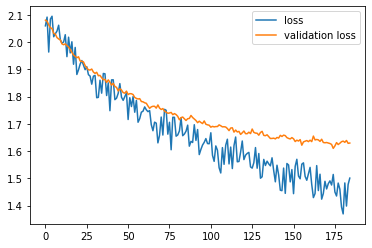

In [55]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([x.cpu().detach().numpy() for x in loss_time], label='loss')
ax.plot(val_loss_time, label='validation loss')
ax.legend();

## Getting the best model

To set your hyperparameters to get the best performance, you'll want to watch the training and validation losses. If your training loss is much lower than the validation loss, you're overfitting. Increase regularization (more dropout) or use a smaller network. If the training and validation losses are close, you're underfitting so you can increase the size of the network.

## Hyperparameters

Here are the hyperparameters for the network.

In defining the model:
* `n_hidden` - The number of units in the hidden layers.
* `n_layers` - Number of hidden LSTM layers to use.

We assume that dropout probability and learning rate will be kept at the default, in this example.

And in training:
* `n_seqs` - Number of sequences running through the network in one pass.
* `n_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lr` - Learning rate for training

Here's some good advice from Andrej Karpathy on training the network. I'm going to copy it in here for your benefit, but also link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

After training, we'll save the model so we can load it again later if we need too. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.

In [19]:
# change the name, for saving multiple files
model_name = 'rnn_2_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

## Sampling

Now that the model is trained, we'll want to sample from it. To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Just keep doing this and you'll generate a bunch of text!

### Top K sampling

Our predictions come from a categorcial probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text.

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [20]:
def sample(net, size, prime='The', top_k=None, cuda=False):
        
    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [21]:
print(sample(net, 2000, prime='Anna', top_k=5, cuda=False))

Anna we were that I had so mory

An' a say out, shat when I'm gone, stard it and the crazy world were dasting
But I heard you crossed them down
Wend of more and to shart to be the street
The laybe is so many to be your laid

We’ll sear missiot off! (Get ’em off!))

Yes, they’re star are day are for too

So hold in there was to stone a what anged
The lifters of has bear the dir they done
In a bolled is a corn

I’d bad long off them saw it’s tonight,
The water we were standing of the brame
When he wants the there will tried to be a some
That we stoned her boybly
And it shinting the died when she saw the while one true show to my flie
Is thinks in your sended and wers to see
I wonder in the said
As I suil about that I don’t who she wants them sere
When she took my best in me to move

Well, I sure with the catter tracked
And I’ll see you
A tray low and this way to my
Talk and talk and sail before tree
I went on them around, honey, so the dark in the water flaces
And the stay of the shoe
An

## Loading a checkpoint

In [22]:
# Here we have loaded in a model that trained over 1 epoch `rnn_1_epoch.net`
with open('rnn_2_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
# Change cuda to True if you are using GPU!
print(sample(loaded, 2000, cuda=False, top_k=5, prime="And Levin said"))

And Levin said, “The well well, there’s no one them doin’ might to say
And they dreamed to hear that you can stone
That we walks
There there and the way
And I waited to searce
When sees and they would have been driver a bring
Well, I’m tried to turn and thankin’ on the sky
I were sometimes a shool
I’m gonna have to serve somebody

Well, it’s something when I'll done with you
That would have this
I’m longin’ it in my soul

That there’s a string on the mine

I can hold the dead blow the dark
It’ll be inseed, standin’ the whole tame
I don’t want me always be some
It’s true, love, that I stream

I want you of take too face

She’s gone again
God knows her had his cart
And the summer’s good to bust along a desered
And I will be in or bad, we washed this ways will belied.

They’ll take you there or some find me or back time into so blues
There’s a word of a blowin’ out from the street of the crazy
Instready to stone and then ask the cristress trees and breakin’
Who wait for my head to be too
